# Étape 1 : Exploration, DataViz et Preprocessing - Données Textuelles

## Contexte et Périmètre du Projet

### Objectif
Classification automatique de produits e-commerce Rakuten en catégories (`prdtypecode`) à partir des informations textuelles (designation, description).

### Périmètre
- **Données textuelles** : designation et description (ce notebook)
- **Données images** : imageid (travail du binôme)
- **Problème** : Classification multi-classes supervisée





## 1. Importation des bibliothèques


In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Configuration de l'affichage
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 200)

# Style pour les graphiques
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


## 2. Chargement des données


In [159]:
# Chargement des données
X_train = pd.read_csv('X_train_update.csv')
Y_train = pd.read_csv('Y_train_CVw08PX.csv')
X_test = pd.read_csv('X_test_update.csv')

print(f"Taille X_train : {X_train.shape}")
print(f"Taille Y_train : {Y_train.shape}")
print(f"Taille X_test : {X_test.shape}")


Taille X_train : (84916, 5)
Taille Y_train : (84916, 2)
Taille X_test : (13812, 5)


In [160]:
# Fusion des données d'entraînement
train_data = pd.merge(X_train, Y_train, left_index=True, right_index=True)
print(f"Taille train_data après fusion : {train_data.shape}")
train_data.head()


Taille train_data après fusion : (84916, 7)


,Unnamed: 0_x,designation,description,productid,imageid,Unnamed: 0_y,prdtypecode
0,0,Olivia: Personalisiertes Notizbuch / 150 Seiten / Punktraster / Ca Din A5 / Rosen-Design,NaN,3804725264,1263597046,0,10
1,1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L'art Et Son Marche Salon D'art Asiatique A Paris - Jacques Barrere - Francois Perrier - La Reforme Des Ventes Aux Encheres Publiques - Le Sna Fete Ses...,NaN,436067568,1008141237,1,2280
2,2,Grand Stylet Ergonomique Bleu Gamepad Nintendo Wii U - Speedlink Pilot Style,PILOT STYLE Touch Pen de marque Speedlink est 1 stylet ergonomique pour GamePad Nintendo Wii U.<br> Pour un confort optimal et une précision maximale sur le GamePad de la Wii U: ce grand stylet ha...,201115110,938777978,2,50
3,3,Peluche Donald - Europe - Disneyland 2000 (Marionnette À Doigt),NaN,50418756,457047496,3,1280
4,4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut organiser un jeu de guerre de boules de neige et s'arranger pour en &ecirc;tre le vainqueur incontest&eacute;. Mais Sophie s'en m&ecirc;le et chambarde ...,278535884,1077757786,4,2705


## 3. Exploration initiale des données textuelles


In [161]:
# Informations générales
print("=== INFORMATIONS GÉNÉRALES ===")
print(f"\nColonnes : {train_data.columns.tolist()}")
print(f"\nTypes de données :")
print(train_data.dtypes)
print(f"\nValeurs manquantes :")
print(train_data.isnull().sum())
print(f"\nPourcentage de valeurs manquantes :")
print((train_data.isnull().sum() / len(train_data) * 100).round(2))


=== INFORMATIONS GÉNÉRALES ===

Colonnes : ['Unnamed: 0_x', 'designation', 'description', 'productid', 'imageid', 'Unnamed: 0_y', 'prdtypecode']

Types de données :
Unnamed: 0_x     int64
designation     object
description     object
productid        int64
imageid          int64
Unnamed: 0_y     int64
prdtypecode      int64
dtype: object

Valeurs manquantes :
Unnamed: 0_x        0
designation         0
description     29800
productid           0
imageid             0
Unnamed: 0_y        0
prdtypecode         0
dtype: int64

Pourcentage de valeurs manquantes :
Unnamed: 0_x     0.00
designation      0.00
description     35.09
productid        0.00
imageid          0.00
Unnamed: 0_y     0.00
prdtypecode      0.00
dtype: float64


In [162]:
# Statistiques sur les colonnes textuelles
print("=== STATISTIQUES SUR LES TEXTES ===")

# Longueur des textes
train_data['len_designation'] = train_data['designation'].astype(str).apply(len)
train_data['len_description'] = train_data['description'].astype(str).apply(len)

# Nombre de mots
train_data['nb_mots_designation'] = train_data['designation'].astype(str).apply(lambda x: len(x.split()))
train_data['nb_mots_description'] = train_data['description'].astype(str).apply(lambda x: len(x.split()) if pd.notna(x) and x != 'nan' else 0)

print("\n=== DESIGNATION ===")
print(f"Longueur moyenne : {train_data['len_designation'].mean():.2f} caractères")
print(f"Longueur médiane : {train_data['len_designation'].median():.2f} caractères")
print(f"Longueur min : {train_data['len_designation'].min()} caractères")
print(f"Longueur max : {train_data['len_designation'].max()} caractères")
print(f"Nombre de mots moyen : {train_data['nb_mots_designation'].mean():.2f} mots")

print("\n=== DESCRIPTION ===")
print(f"Longueur moyenne : {train_data['len_description'].mean():.2f} caractères")
print(f"Longueur médiane : {train_data['len_description'].median():.2f} caractères")
print(f"Longueur min : {train_data['len_description'].min()} caractères")
print(f"Longueur max : {train_data['len_description'].max()} caractères")
print(f"Nombre de mots moyen : {train_data['nb_mots_description'].mean():.2f} mots")

# Descriptions vides
descriptions_vides = train_data['description'].isna().sum() + (train_data['description'].astype(str) == 'nan').sum()
print(f"\nDescriptions vides ou NaN : {descriptions_vides} ({descriptions_vides/len(train_data)*100:.2f}%)")


=== STATISTIQUES SUR LES TEXTES ===

=== DESIGNATION ===
Longueur moyenne : 70.16 caractères
Longueur médiane : 64.00 caractères
Longueur min : 11 caractères
Longueur max : 250 caractères
Nombre de mots moyen : 11.56 mots

=== DESCRIPTION ===
Longueur moyenne : 525.61 caractères
Longueur médiane : 231.00 caractères
Longueur min : 1 caractères
Longueur max : 12451 caractères
Nombre de mots moyen : 80.17 mots

Descriptions vides ou NaN : 59600 (70.19%)


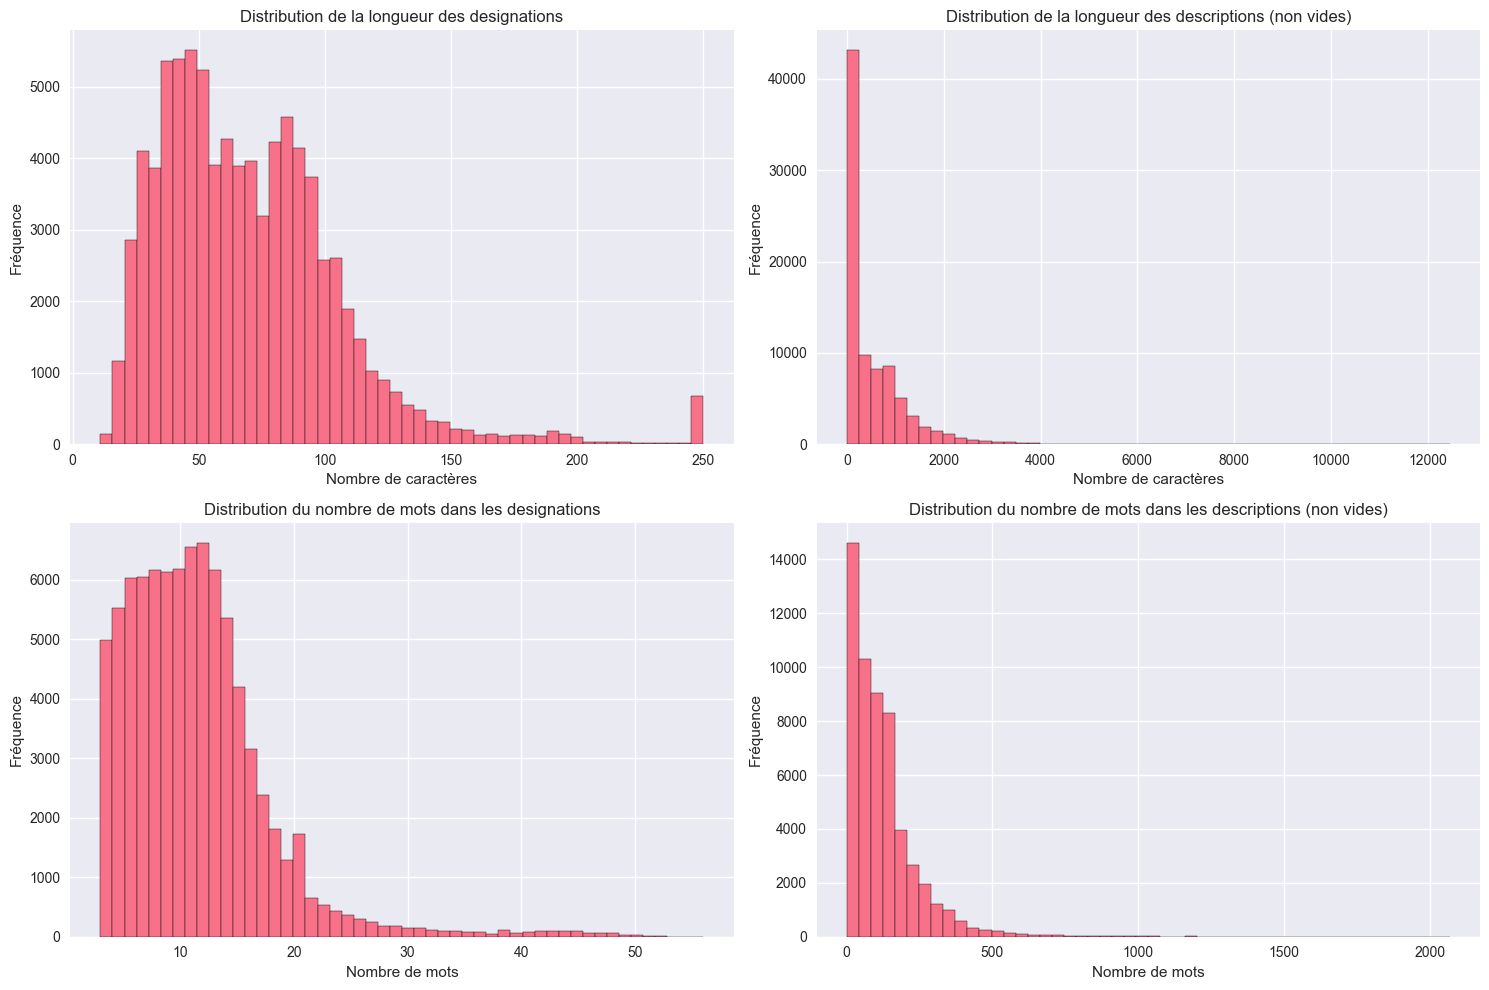

In [163]:
# Visualisations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribution de la longueur des designations
axes[0, 0].hist(train_data['len_designation'], bins=50, edgecolor='black')
axes[0, 0].set_title('Distribution de la longueur des designations')
axes[0, 0].set_xlabel('Nombre de caractères')
axes[0, 0].set_ylabel('Fréquence')

# Distribution de la longueur des descriptions
axes[0, 1].hist(train_data['len_description'][train_data['len_description'] > 0], bins=50, edgecolor='black')
axes[0, 1].set_title('Distribution de la longueur des descriptions (non vides)')
axes[0, 1].set_xlabel('Nombre de caractères')
axes[0, 1].set_ylabel('Fréquence')

# Distribution du nombre de mots - designation
axes[1, 0].hist(train_data['nb_mots_designation'], bins=50, edgecolor='black')
axes[1, 0].set_title('Distribution du nombre de mots dans les designations')
axes[1, 0].set_xlabel('Nombre de mots')
axes[1, 0].set_ylabel('Fréquence')

# Distribution du nombre de mots - description
axes[1, 1].hist(train_data['nb_mots_description'][train_data['nb_mots_description'] > 0], bins=50, edgecolor='black')
axes[1, 1].set_title('Distribution du nombre de mots dans les descriptions (non vides)')
axes[1, 1].set_xlabel('Nombre de mots')
axes[1, 1].set_ylabel('Fréquence')

plt.tight_layout()
plt.show()


## 4. Analyse des catégories (prdtypecode)


=== DISTRIBUTION DES CATÉGORIES ===
Nombre total de catégories : 27

Top 20 catégories :
prdtypecode
10      3116
40      2508
50      1681
60       832
1140    2671
1160    3953
1180     764
1280    4870
1281    2070
1300    5045
1301     807
1302    2491
1320    3241
1560    5073
1920    4303
1940     803
2060    4993
2220     824
2280    4760
2403    4774
Name: count, dtype: int64


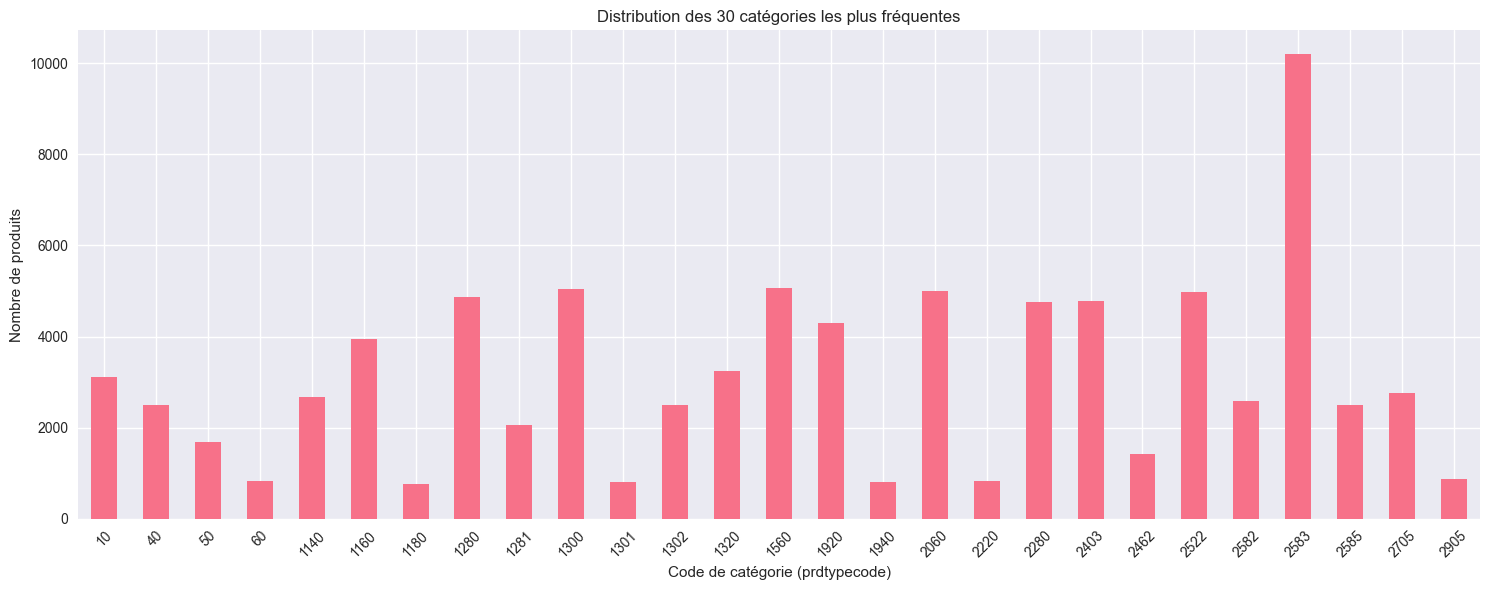

In [164]:
# Distribution des catégories
print("=== DISTRIBUTION DES CATÉGORIES ===")
category_counts = train_data['prdtypecode'].value_counts().sort_index()
print(f"Nombre total de catégories : {train_data['prdtypecode'].nunique()}")
print(f"\nTop 20 catégories :")
print(category_counts.head(20))

# Visualisation
plt.figure(figsize=(15, 6))
category_counts.head(30).plot(kind='bar')
plt.title('Distribution des 30 catégories les plus fréquentes')
plt.xlabel('Code de catégorie (prdtypecode)')
plt.ylabel('Nombre de produits')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [165]:
# Analyse du déséquilibre des classes
print("=== ANALYSE DU DÉSÉQUILIBRE ===")
category_proportions = train_data['prdtypecode'].value_counts(normalize=True)
print(f"Catégorie la plus fréquente : {category_proportions.max():.4f} ({category_proportions.max()*100:.2f}%)")
print(f"Catégorie la moins fréquente : {category_proportions.min():.4f} ({category_proportions.min()*100:.2f}%)")
print(f"Ratio max/min : {category_proportions.max() / category_proportions.min():.2f}")


=== ANALYSE DU DÉSÉQUILIBRE ===
Catégorie la plus fréquente : 0.1202 (12.02%)
Catégorie la moins fréquente : 0.0090 (0.90%)
Ratio max/min : 13.36


## 5. Nettoyage des données textuelles


In [166]:
def nettoyer_texte(texte):
    """
    Fonction pour nettoyer un texte
    """
    if pd.isna(texte) or texte == 'nan':
        return ''
    
    texte = str(texte)
    
    # Suppression des balises HTML
    texte = re.sub(r'<[^>]+>', '', texte)
    
    # Remplacer les entités HTML
    texte = texte.replace('&nbsp;', ' ')
    texte = texte.replace('&amp;', '&')
    texte = texte.replace('&lt;', '<')
    texte = texte.replace('&gt;', '>')
    texte = texte.replace('&quot;', '"')
    texte = texte.replace('&#39;', "'")
    texte = texte.replace('&eacute;', 'é')
    texte = texte.replace('&egrave;', 'è')
    texte = texte.replace('&ecirc;', 'ê')
    texte = texte.replace('&agrave;', 'à')
    
    # Normaliser les espaces multiples
    texte = re.sub(r'\s+', ' ', texte)
    
    # Supprimer les espaces en début et fin
    texte = texte.strip()
    
    return texte


In [167]:
# Application du nettoyage
print("Nettoyage des données textuelles...")

train_data['designation_clean'] = train_data['designation'].apply(nettoyer_texte)
train_data['description_clean'] = train_data['description'].apply(nettoyer_texte)

# Fusion des textes nettoyés
train_data['texte_complet'] = train_data['designation_clean'] + ' ' + train_data['description_clean']
train_data['texte_complet'] = train_data['texte_complet'].str.strip()

print("Nettoyage terminé !")

# Statistiques sur les modifications
designation_modifiees = (train_data['designation'] != train_data['designation_clean']).sum()
description_modifiees = (train_data['description'].astype(str) != train_data['description_clean'].astype(str)).sum()
print(f"\n=== STATISTIQUES DE NETTOYAGE ===")
print(f"Designations modifiées : {designation_modifiees} sur {len(train_data)} ({designation_modifiees/len(train_data)*100:.2f}%)")
print(f"Descriptions modifiées : {description_modifiees} sur {len(train_data)} ({description_modifiees/len(train_data)*100:.2f}%)")

# Trouver des exemples qui montrent des différences
print(f"\n=== EXEMPLES DE NETTOYAGE ===")

# Exemples de designations modifiées
designation_changed = train_data[train_data['designation'] != train_data['designation_clean']]
if len(designation_changed) > 0:
    print(f"\n--- Exemples de designations modifiées ({min(3, len(designation_changed))} exemples) ---")
    for i in range(min(3, len(designation_changed))):
        idx = designation_changed.index[i]
        print(f"\nExemple {i+1} (index: {idx}):")
        print(f"  Avant : {train_data.loc[idx, 'designation'][:150]}{'...' if len(train_data.loc[idx, 'designation']) > 150 else ''}")
        print(f"  Après : {train_data.loc[idx, 'designation_clean'][:150]}{'...' if len(train_data.loc[idx, 'designation_clean']) > 150 else ''}")
else:
    print("\n--- Aucune designation n'a été modifiée (pas de HTML/entités HTML détectées) ---")
    print("Exemple d'une designation (identique avant/après car déjà propre) :")
    print(f"  {train_data['designation'].iloc[0]}")

# Exemples de descriptions modifiées (seulement celles qui ne sont pas vides)
description_changed = train_data[
    (train_data['description'].astype(str) != train_data['description_clean'].astype(str)) &
    (train_data['description'].notna()) &
    (train_data['description'].astype(str) != 'nan')
]
if len(description_changed) > 0:
    print(f"\n--- Exemples de descriptions modifiées ({min(2, len(description_changed))} exemples) ---")
    for i in range(min(2, len(description_changed))):
        idx = description_changed.index[i]
        desc_avant = str(train_data.loc[idx, 'description'])[:200]
        desc_apres = train_data.loc[idx, 'description_clean'][:200]
        print(f"\nExemple {i+1} (index: {idx}):")
        print(f"  Avant : {desc_avant}{'...' if len(str(train_data.loc[idx, 'description'])) > 200 else ''}")
        print(f"  Après : {desc_apres}{'...' if len(train_data.loc[idx, 'description_clean']) > 200 else ''}")


Nettoyage des données textuelles...
Nettoyage terminé !

=== STATISTIQUES DE NETTOYAGE ===
Designations modifiées : 4313 sur 84916 (5.08%)
Descriptions modifiées : 71635 sur 84916 (84.36%)

=== EXEMPLES DE NETTOYAGE ===

--- Exemples de designations modifiées (3 exemples) ---

Exemple 1 (index: 27):
  Avant : Faber-Castell Lot De 3 Crayons De Couleur Polychromos Mine 38mm À L&#39;Huile Vert Emeraude
  Après : Faber-Castell Lot De 3 Crayons De Couleur Polychromos Mine 38mm À L'Huile Vert Emeraude

Exemple 2 (index: 46):
  Avant : Vassivière -En-Limousin.  Le Jardin Art Et Lieu De Mémoire
  Après : Vassivière -En-Limousin. Le Jardin Art Et Lieu De Mémoire

Exemple 3 (index: 57):
  Avant : Lot De 5 Livres Grans Peintres 
  Après : Lot De 5 Livres Grans Peintres

--- Exemples de descriptions modifiées (2 exemples) ---

Exemple 1 (index: 2):
  Avant : PILOT STYLE Touch Pen de marque Speedlink est 1 stylet ergonomique pour GamePad Nintendo Wii U.<br> Pour un confort optimal et une précision 

## 6. Visualisations approfondies (DataViz)

### Visualisation 1 : Distribution des catégories avec analyse du déséquilibre


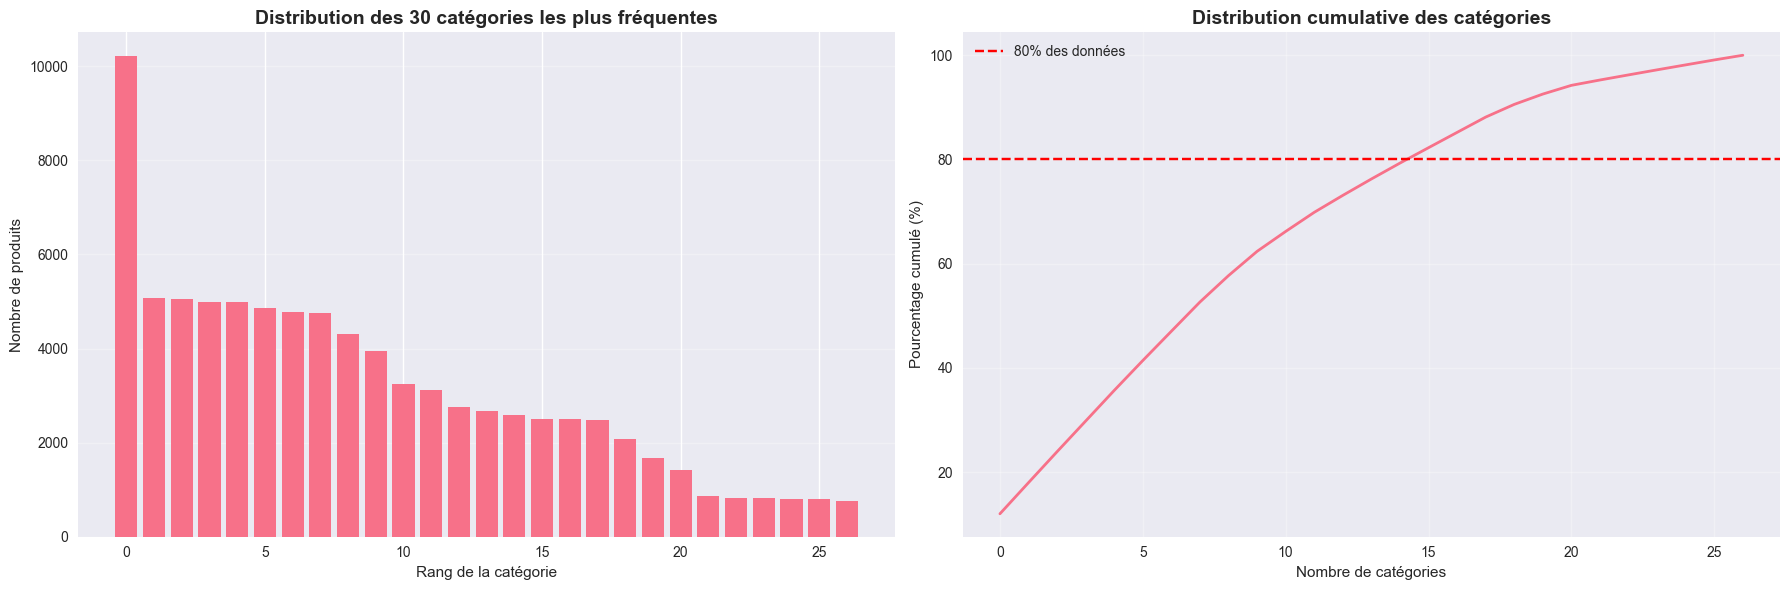

=== ANALYSE STATISTIQUE DU DÉSÉQUILIBRE ===
Nombre total de catégories : 27
Catégorie la plus fréquente : 2583 (10209 produits, 12.02%)
Catégorie la moins fréquente : 1180 (764 produits, 0.90%)
Ratio max/min : 13.36

Nombre de catégories représentant 80% des données : 15
Nombre de catégories représentant 50% des données : 7

Coefficient de variation : 0.67 (plus élevé = plus déséquilibré)


In [168]:
# Visualisation 1 : Distribution complète des catégories
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Graphique 1 : Distribution des catégories (top 30)
category_counts = train_data['prdtypecode'].value_counts().sort_values(ascending=False)
axes[0].bar(range(len(category_counts.head(30))), category_counts.head(30).values)
axes[0].set_title('Distribution des 30 catégories les plus fréquentes', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Rang de la catégorie')
axes[0].set_ylabel('Nombre de produits')
axes[0].grid(axis='y', alpha=0.3)

# Graphique 2 : Distribution cumulative
cumulative = category_counts.cumsum() / category_counts.sum() * 100
axes[1].plot(range(len(cumulative)), cumulative.values, linewidth=2)
axes[1].axhline(y=80, color='r', linestyle='--', label='80% des données')
axes[1].set_title('Distribution cumulative des catégories', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Nombre de catégories')
axes[1].set_ylabel('Pourcentage cumulé (%)')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Analyse statistique
print("=== ANALYSE STATISTIQUE DU DÉSÉQUILIBRE ===")
print(f"Nombre total de catégories : {train_data['prdtypecode'].nunique()}")
print(f"Catégorie la plus fréquente : {category_counts.index[0]} ({category_counts.iloc[0]} produits, {category_counts.iloc[0]/len(train_data)*100:.2f}%)")
print(f"Catégorie la moins fréquente : {category_counts.index[-1]} ({category_counts.iloc[-1]} produits, {category_counts.iloc[-1]/len(train_data)*100:.2f}%)")
print(f"Ratio max/min : {category_counts.iloc[0] / category_counts.iloc[-1]:.2f}")
print(f"\nNombre de catégories représentant 80% des données : {(cumulative <= 80).sum()}")
print(f"Nombre de catégories représentant 50% des données : {(cumulative <= 50).sum()}")

# Test statistique : Coefficient de variation pour mesurer le déséquilibre
cv = category_counts.std() / category_counts.mean()
print(f"\nCoefficient de variation : {cv:.2f} (plus élevé = plus déséquilibré)")


### Visualisation 2 : Relation entre longueur des textes et catégories


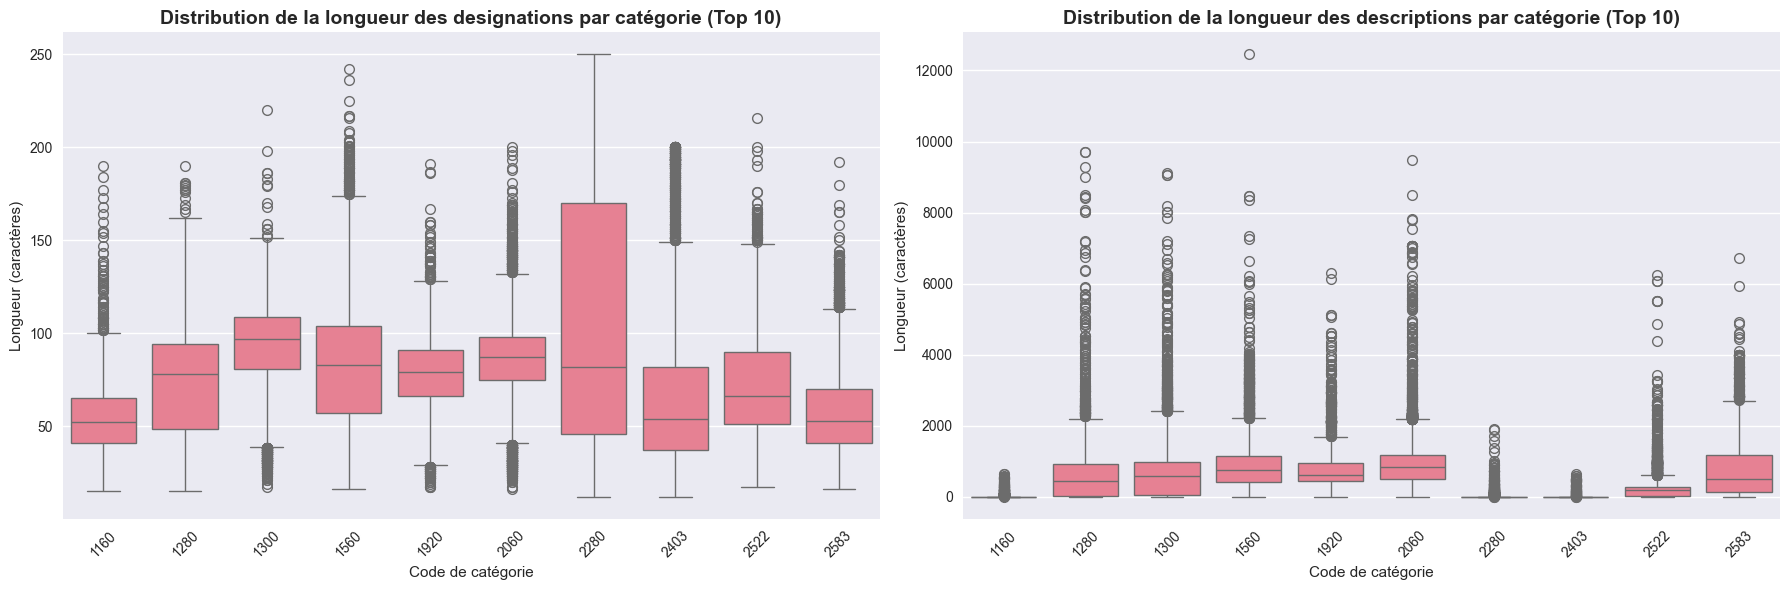

=== TEST STATISTIQUE : ANOVA ===
ANOVA sur longueur des designations : F=1164.99, p-value=0.00e+00
Les catégories ont des longueurs de designation significativement différentes (α=0.05)


In [169]:
# Visualisation 2 : Longueur des textes par catégorie (top 10 catégories)
top_categories = category_counts.head(10).index
train_top_cat = train_data[train_data['prdtypecode'].isin(top_categories)]

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Boxplot de la longueur des designations par catégorie
sns.boxplot(data=train_top_cat, x='prdtypecode', y='len_designation', ax=axes[0])
axes[0].set_title('Distribution de la longueur des designations par catégorie (Top 10)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Code de catégorie')
axes[0].set_ylabel('Longueur (caractères)')
axes[0].tick_params(axis='x', rotation=45)

# Boxplot de la longueur des descriptions par catégorie
train_top_cat_with_desc = train_top_cat[train_top_cat['len_description'] > 0]
sns.boxplot(data=train_top_cat_with_desc, x='prdtypecode', y='len_description', ax=axes[1])
axes[1].set_title('Distribution de la longueur des descriptions par catégorie (Top 10)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Code de catégorie')
axes[1].set_ylabel('Longueur (caractères)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Test statistique : ANOVA pour vérifier si les différences sont significatives
from scipy import stats

print("=== TEST STATISTIQUE : ANOVA ===")
# Test ANOVA sur les longueurs de designation
groups = [train_top_cat[train_top_cat['prdtypecode'] == cat]['len_designation'].values 
          for cat in top_categories]
f_stat, p_value = stats.f_oneway(*groups)
print(f"ANOVA sur longueur des designations : F={f_stat:.2f}, p-value={p_value:.2e}")
print(f"Les catégories ont des longueurs de designation {'significativement différentes' if p_value < 0.05 else 'non significativement différentes'} (α=0.05)")


### Visualisation 3 : Analyse de la présence/absence des descriptions


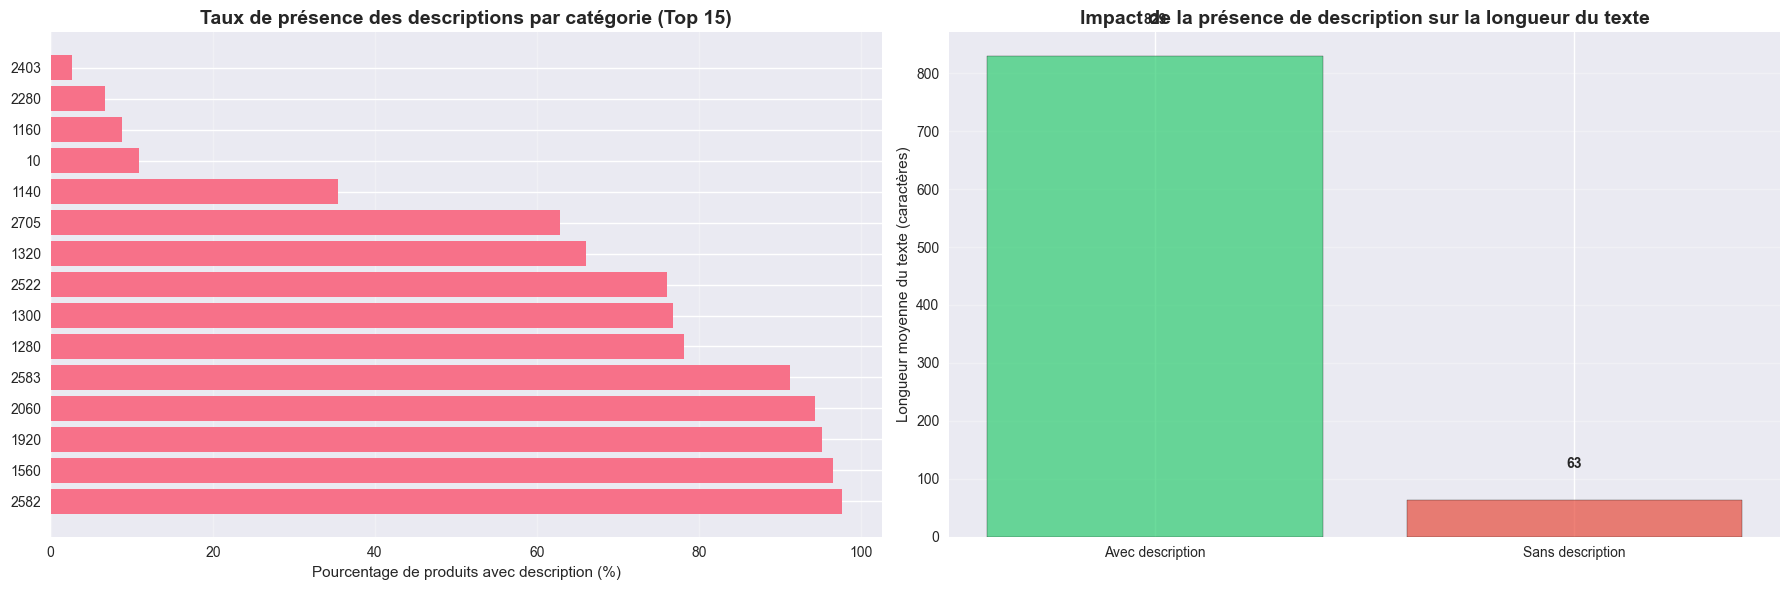

=== TEST STATISTIQUE : MANN-WHITNEY ===
Mann-Whitney U test : U=1613517691.00, p-value=0.00e+00
Les textes avec description sont significativement plus longs (α=0.05)

Longueur moyenne avec description : 829.04 caractères
Longueur moyenne sans description : 63.33 caractères
Différence : 765.72 caractères (1209.2% plus long)


In [170]:
# Visualisation 3 : Présence des descriptions par catégorie
train_data['has_description'] = (train_data['description_clean'] != '') & (train_data['description_clean'].notna())

# Verifions que texte_complet existe 
if 'texte_complet' not in train_data.columns:
    train_data['texte_complet'] = train_data['designation_clean'] + ' ' + train_data['description_clean']
    train_data['texte_complet'] = train_data['texte_complet'].str.strip()

# Calculer la longueur du texte complet 
if 'len_texte_complet' not in train_data.columns:
    train_data['len_texte_complet'] = train_data['texte_complet'].apply(len)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Graphique 1 : Pourcentage de descriptions présentes par catégorie (top 15)
top_15_cat = category_counts.head(15).index
desc_presence = train_data[train_data['prdtypecode'].isin(top_15_cat)].groupby('prdtypecode')['has_description'].agg(['mean', 'count'])
desc_presence = desc_presence.sort_values('mean', ascending=False)

axes[0].barh(range(len(desc_presence)), desc_presence['mean'].values * 100)
axes[0].set_yticks(range(len(desc_presence)))
axes[0].set_yticklabels(desc_presence.index)
axes[0].set_xlabel('Pourcentage de produits avec description (%)')
axes[0].set_title('Taux de présence des descriptions par catégorie (Top 15)', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Graphique 2 : Impact sur la performance potentielle
# Comparaison longueur moyenne du texte complet avec/sans description
with_desc = train_data[train_data['has_description']]['len_texte_complet'].mean()
without_desc = train_data[~train_data['has_description']]['len_texte_complet'].mean()

categories = ['Avec description', 'Sans description']
lengths = [with_desc, without_desc]
colors = ['#2ecc71', '#e74c3c']

axes[1].bar(categories, lengths, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Longueur moyenne du texte (caractères)')
axes[1].set_title('Impact de la présence de description sur la longueur du texte', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Ajoutons les valeurs sur les barres
for i, v in enumerate(lengths):
    axes[1].text(i, v + 50, f'{v:.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Test statistique : Test de Mann-Whitney
print("=== TEST STATISTIQUE : MANN-WHITNEY ===")
with_desc_lengths = train_data[train_data['has_description']]['len_texte_complet']
without_desc_lengths = train_data[~train_data['has_description']]['len_texte_complet']
stat, p_value = stats.mannwhitneyu(with_desc_lengths, without_desc_lengths, alternative='two-sided')
print(f"Mann-Whitney U test : U={stat:.2f}, p-value={p_value:.2e}")
print(f"Les textes avec description sont {'significativement plus longs' if p_value < 0.05 else 'non significativement différents'} (α=0.05)")
print(f"\nLongueur moyenne avec description : {with_desc:.2f} caractères")
print(f"Longueur moyenne sans description : {without_desc:.2f} caractères")
print(f"Différence : {with_desc - without_desc:.2f} caractères ({((with_desc - without_desc) / without_desc * 100):.1f}% plus long)")


### Visualisation 4 : Analyse des langues dans les données


⚠️ Module 'langdetect' non installé. Utilisation d'une méthode de détection simple basée sur les caractères.
Détection de la langue (échantillon de 5000 produits)...


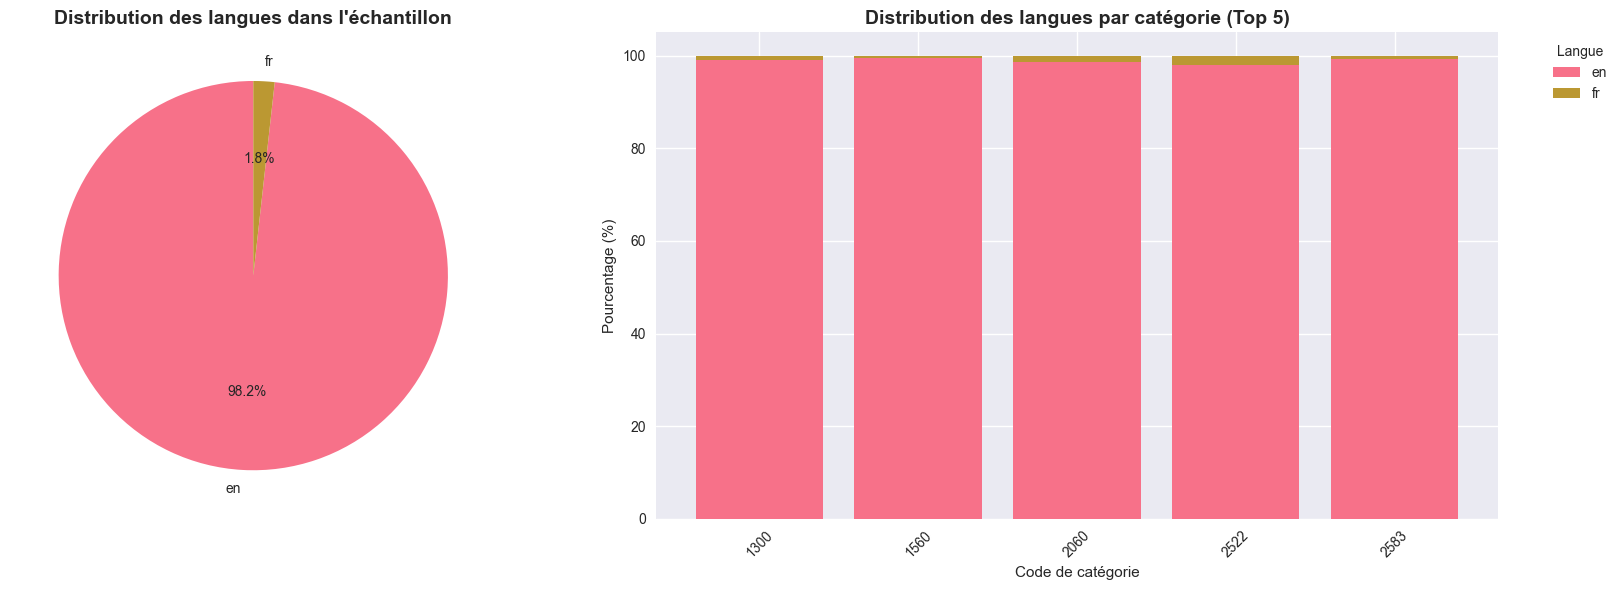

=== ANALYSE DES LANGUES ===
Distribution des langues dans l'échantillon :
langue
en    4912
fr      88
Name: count, dtype: int64

Pourcentage :
langue
en    98.24
fr     1.76
Name: count, dtype: float64


In [171]:
# Visualisation 4 : Distribution des langues et impact sur les catégories

# Verification que texte_complet existe
if 'texte_complet' not in train_data.columns:
    train_data['texte_complet'] = train_data['designation_clean'] + ' ' + train_data['description_clean']
    train_data['texte_complet'] = train_data['texte_complet'].str.strip()

# S'assurer que category_counts est défini
if 'category_counts' not in locals():
    category_counts = train_data['prdtypecode'].value_counts().sort_values(ascending=False)

# Détection de la langue
try:
    from langdetect import detect, LangDetectException
    USE_LANGDETECT = True
except ImportError:
    USE_LANGDETECT = False
    print("⚠️ Module 'langdetect' non installé. Utilisation d'une méthode de détection simple basée sur les caractères.")

def detecter_langue(texte):
    """Détection de la langue avec gestion d'erreurs"""
    if not texte or len(texte) < 10:
        return 'vide'
    
    if USE_LANGDETECT:
        try:
            return detect(texte)
        except (LangDetectException, Exception):
            return 'inconnu'
    else:
        # Méthode alternative basée sur les caractères français
        caracteres_fr = set('éèêëàâäôöùûüçÉÈÊËÀÂÄÔÖÙÛÜÇ')
        nb_caracteres_fr = sum(1 for c in texte if c in caracteres_fr)
        
        if nb_caracteres_fr > len(texte) * 0.05:  # Plus de 5% de caractères français
            return 'fr'
        elif any(c.isalpha() for c in texte):  # Contient des lettres
            return 'en'
        else:
            return 'autre'

# Détection de la langue (sur un échantillon pour la performance)
print("Détection de la langue (échantillon de 5000 produits)...")
sample_indices = np.random.choice(len(train_data), min(5000, len(train_data)), replace=False)
train_sample = train_data.iloc[sample_indices].copy()
train_sample['langue'] = train_sample['texte_complet'].apply(detecter_langue)

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Graphique 1 : Distribution des langues
langue_counts = train_sample['langue'].value_counts()
axes[0].pie(langue_counts.values, labels=langue_counts.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Distribution des langues dans l\'échantillon', fontsize=14, fontweight='bold')

# Graphique 2 : Langue par catégorie (top 5 catégories)
top_5_cat = category_counts.head(5).index
train_top5 = train_sample[train_sample['prdtypecode'].isin(top_5_cat)]
langue_by_cat = pd.crosstab(train_top5['prdtypecode'], train_top5['langue'], normalize='index') * 100

langue_by_cat.plot(kind='bar', stacked=True, ax=axes[1], width=0.8)
axes[1].set_title('Distribution des langues par catégorie (Top 5)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Code de catégorie')
axes[1].set_ylabel('Pourcentage (%)')
axes[1].legend(title='Langue', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("=== ANALYSE DES LANGUES ===")
print(f"Distribution des langues dans l'échantillon :")
print(langue_counts)
print(f"\nPourcentage :")
print(langue_counts / len(train_sample) * 100)


### Visualisation 5 : Analyse de la complexité lexicale


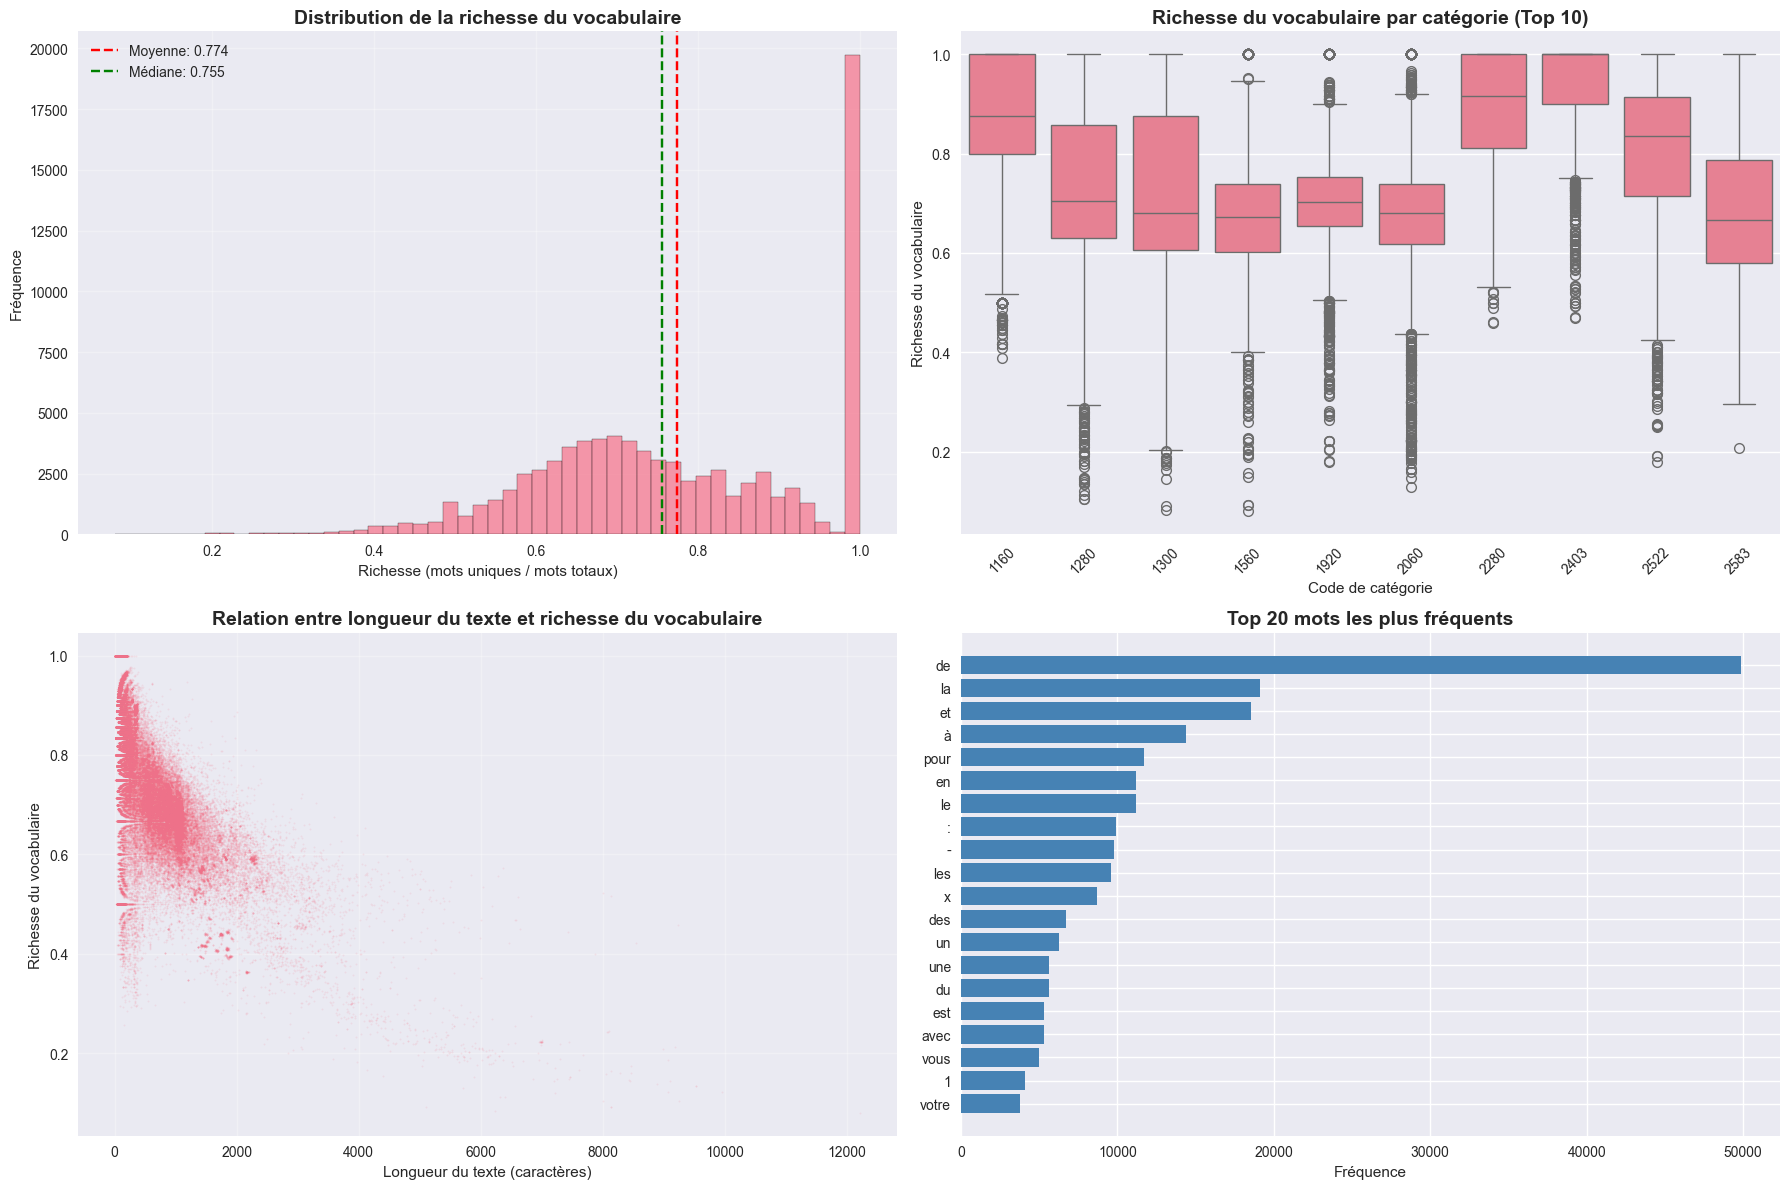

=== TEST STATISTIQUE : CORRÉLATION ===
Corrélation entre longueur et richesse : -0.6757
Corrélation modérée


In [172]:
# Visualisation 5 : Complexité lexicale (richesse du vocabulaire)
def calculer_richesse_vocabulaire(texte):
    """Calcule la richesse du vocabulaire (nombre de mots uniques / nombre total de mots)"""
    if not texte or len(texte) == 0:
        return 0
    mots = texte.lower().split()
    if len(mots) == 0:
        return 0
    return len(set(mots)) / len(mots)

train_data['richesse_vocab'] = train_data['texte_complet'].apply(calculer_richesse_vocabulaire)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Graphique 1 : Distribution de la richesse du vocabulaire
axes[0, 0].hist(train_data['richesse_vocab'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(train_data['richesse_vocab'].mean(), color='r', linestyle='--', 
                   label=f'Moyenne: {train_data["richesse_vocab"].mean():.3f}')
axes[0, 0].axvline(train_data['richesse_vocab'].median(), color='g', linestyle='--', 
                   label=f'Médiane: {train_data["richesse_vocab"].median():.3f}')
axes[0, 0].set_title('Distribution de la richesse du vocabulaire', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Richesse (mots uniques / mots totaux)')
axes[0, 0].set_ylabel('Fréquence')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Graphique 2 : Richesse du vocabulaire par catégorie (top 10)
top_10_cat = category_counts.head(10).index
train_top10 = train_data[train_data['prdtypecode'].isin(top_10_cat)]
sns.boxplot(data=train_top10, x='prdtypecode', y='richesse_vocab', ax=axes[0, 1])
axes[0, 1].set_title('Richesse du vocabulaire par catégorie (Top 10)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Code de catégorie')
axes[0, 1].set_ylabel('Richesse du vocabulaire')
axes[0, 1].tick_params(axis='x', rotation=45)

# Graphique 3 : Relation longueur vs richesse
axes[1, 0].scatter(train_data['len_texte_complet'], train_data['richesse_vocab'], 
                   alpha=0.1, s=1)
axes[1, 0].set_title('Relation entre longueur du texte et richesse du vocabulaire', 
                     fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Longueur du texte (caractères)')
axes[1, 0].set_ylabel('Richesse du vocabulaire')
axes[1, 0].grid(alpha=0.3)

# Graphique 4 : Mots les plus fréquents (top 20)
from collections import Counter
all_words = []
for texte in train_data['texte_complet'].head(10000):  # Échantillon pour performance
    if texte:
        mots = texte.lower().split()
        all_words.extend(mots)

word_counts = Counter(all_words)
top_words = word_counts.most_common(20)
words, counts = zip(*top_words)

axes[1, 1].barh(range(len(words)), counts, color='steelblue')
axes[1, 1].set_yticks(range(len(words)))
axes[1, 1].set_yticklabels(words)
axes[1, 1].set_xlabel('Fréquence')
axes[1, 1].set_title('Top 20 mots les plus fréquents', fontsize=14, fontweight='bold')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

# Test statistique : Corrélation
print("=== TEST STATISTIQUE : CORRÉLATION ===")
correlation = train_data['len_texte_complet'].corr(train_data['richesse_vocab'])
print(f"Corrélation entre longueur et richesse : {correlation:.4f}")
if abs(correlation) < 0.1:
    print("Corrélation très faible - pas de relation linéaire forte")
elif abs(correlation) < 0.3:
    print("Corrélation faible")
elif abs(correlation) < 0.7:
    print("Corrélation modérée")
else:
    print("Corrélation forte")


## 8. Preprocessing avancé


In [173]:
# Preprocessing avancé avec NLTK (ou méthode alternative)

# S'assurer que texte_complet existe
if 'texte_complet' not in train_data.columns:
    train_data['texte_complet'] = train_data['designation_clean'] + ' ' + train_data['description_clean']
    train_data['texte_complet'] = train_data['texte_complet'].str.strip()

# Vérifier si NLTK est disponible
try:
    import nltk
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize
    from nltk.stem import SnowballStemmer
    
    # Télécharger les ressources NLTK nécessaires (à faire une seule fois)
    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        nltk.download('punkt', quiet=True)
    
    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('stopwords', quiet=True)
    
    # Initialiser le stemmer français
    stemmer_fr = SnowballStemmer('french')
    stemmer_en = SnowballStemmer('english')
    
    # Stop words multilingues
    stop_words_fr = set(stopwords.words('french'))
    stop_words_en = set(stopwords.words('english'))
    stop_words = stop_words_fr.union(stop_words_en)
    
    USE_NLTK = True
    print("✅ NLTK disponible - Utilisation du preprocessing avancé avec NLTK")
    
except ImportError:
    USE_NLTK = False
    print("⚠️ NLTK non installé - Utilisation d'une méthode de preprocessing simplifiée")
    print("   Pour installer NLTK : pip install nltk")
    
    # Stop words basiques (liste réduite)
    stop_words_fr_basic = {'le', 'la', 'les', 'de', 'du', 'des', 'un', 'une', 'et', 'ou', 
                           'à', 'pour', 'dans', 'sur', 'avec', 'par', 'est', 'sont', 'être', 'avoir'}
    stop_words_en_basic = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 
                           'for', 'of', 'with', 'by', 'is', 'are', 'was', 'were', 'be', 'have'}
    stop_words = stop_words_fr_basic.union(stop_words_en_basic)

def preprocess_texte_avance(texte, remove_stopwords=True, stem=True):
    """
    Preprocessing avancé d'un texte
    """
    if not texte or len(texte) == 0:
        return ''
    
    # Convertir en minuscules
    texte = texte.lower()
    
    # Supprimer les caractères spéciaux (garder lettres, chiffres, espaces)
    texte = re.sub(r'[^a-z0-9\s]', ' ', texte)
    
    if USE_NLTK:
        # Tokenisation avec NLTK
        tokens = word_tokenize(texte)
        
        # Supprimer les stop words
        if remove_stopwords:
            tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
        
        # Stemming
        if stem:
            # Détection simple de la langue basée sur les caractères français
            # Pour chaque token, on essaie les deux stemmers et on garde celui qui change le moins
            # (méthode simple, mais on pourrait améliorer avec une vraie détection de langue)
            tokens_stemmed = []
            for token in tokens:
                # Essayer le stemmer français
                stem_fr = stemmer_fr.stem(token)
                # Essayer le stemmer anglais
                stem_en = stemmer_en.stem(token)
                # Si le token contient des caractères français typiques, utiliser le stemmer français
                if any(c in token for c in 'éèêëàâäôöùûüç'):
                    tokens_stemmed.append(stem_fr)
                else:
                    # Par défaut, utiliser le stemmer anglais (la majorité des textes sont en anglais)
                    tokens_stemmed.append(stem_en)
            tokens = tokens_stemmed
    else:
        # Méthode alternative sans NLTK
        tokens = texte.split()
        
        # Supprimer les stop words
        if remove_stopwords:
            tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
        
        # Pas de stemming sans NLTK (on garde les mots tels quels)
        # Note: On pourrait implémenter un stemmer simple, mais on le laisse pour l'instant
    
    # Rejoindre les tokens
    texte_clean = ' '.join(tokens)
    
    return texte_clean

# Application sur un échantillon pour tester
print("\nPreprocessing avancé (échantillon de 1000 produits pour test)...")
sample_indices = np.random.choice(len(train_data), min(1000, len(train_data)), replace=False)
train_sample_prep = train_data.iloc[sample_indices].copy()

train_sample_prep['texte_preprocessed'] = train_sample_prep['texte_complet'].apply(
    lambda x: preprocess_texte_avance(x, remove_stopwords=True, stem=USE_NLTK)  # Stemming seulement si NLTK disponible
)

print("\nExemples de preprocessing (comparaison avant/après pour les mêmes textes) :")
if len(train_sample_prep) > 0:
    # Afficher plusieurs exemples pour montrer le preprocessing
    for i in range(min(5, len(train_sample_prep))):
        idx = train_sample_prep.index[i]
        texte_avant = train_sample_prep['texte_complet'].iloc[i]
        texte_apres = train_sample_prep['texte_preprocessed'].iloc[i]
        print(f"\n--- Exemple {i+1} (index original: {idx}) ---")
        print(f"Avant : {texte_avant[:200]}{'...' if len(texte_avant) > 200 else ''}")
        print(f"Après : {texte_apres[:200]}{'...' if len(texte_apres) > 200 else ''}")


⚠️ NLTK non installé - Utilisation d'une méthode de preprocessing simplifiée
   Pour installer NLTK : pip install nltk

Preprocessing avancé (échantillon de 1000 produits pour test)...

Exemples de preprocessing (comparaison avant/après pour les mêmes textes) :

--- Exemple 1 (index original: 8228) ---
Avant : Jeu De Société Les Goonies Jeu de société les Goonies. Issu du film culte. Arpentez des tunnels tortueux déjouez les boum j't'attrape et échappez aux Fratelli pour dénicher le trésor caché du pirate W...
Après : jeu soci goonies jeu soci goonies issu film culte arpentez tunnels tortueux jouez boum attrape chappez aux fratelli nicher sor cach pirate willy borgne

--- Exemple 2 (index original: 70030) ---
Avant : Tour De Lit Bébé Tressé Pare-Chocs Velours Protection Bébé Sécurité Tour De Canapé Souple Pour Bébé Protection Chambre Décor (2m) Rose
Après : tour lit tress pare chocs velours protection curit tour canap souple protection chambre cor rose

--- Exemple 3 (index original: 1

## 9. Features additionnelles


In [174]:
# Création de features additionnelles

# S'assurer que les colonnes nécessaires existent
if 'texte_complet' not in train_data.columns:
    train_data['texte_complet'] = train_data['designation_clean'] + ' ' + train_data['description_clean']
    train_data['texte_complet'] = train_data['texte_complet'].str.strip()

# Définir la fonction calculer_richesse_vocabulaire si elle n'existe pas
if 'calculer_richesse_vocabulaire' not in globals():
    def calculer_richesse_vocabulaire(texte):
        """Calcule la richesse du vocabulaire (nombre de mots uniques / nombre total de mots)"""
        if not texte or len(texte) == 0:
            return 0
        mots = texte.lower().split()
        if len(mots) == 0:
            return 0
        return len(set(mots)) / len(mots)

def creer_features_additionnelles(df):
    """
    Crée des features additionnelles à partir des textes
    """
    df_features = df.copy()
    
    # Features de longueur
    df_features['len_designation'] = df_features['designation_clean'].apply(len)
    df_features['len_description'] = df_features['description_clean'].apply(len)
    df_features['len_texte_complet'] = df_features['texte_complet'].apply(len)
    
    # Features de nombre de mots
    df_features['nb_mots_designation'] = df_features['designation_clean'].apply(lambda x: len(x.split()) if x else 0)
    df_features['nb_mots_description'] = df_features['description_clean'].apply(lambda x: len(x.split()) if x else 0)
    df_features['nb_mots_total'] = df_features['texte_complet'].apply(lambda x: len(x.split()) if x else 0)
    
    # Features binaires
    df_features['has_description'] = (df_features['description_clean'] != '') & (df_features['description_clean'].notna())
    
    # Features de complexité
    df_features['richesse_vocab'] = df_features['texte_complet'].apply(calculer_richesse_vocabulaire)
    df_features['moyenne_longueur_mots'] = df_features['texte_complet'].apply(
        lambda x: np.mean([len(mot) for mot in x.split()]) if x and len(x.split()) > 0 else 0
    )
    
    # Features de ponctuation (si pas encore supprimée)
    df_features['nb_caracteres_speciaux'] = df_features['texte_complet'].apply(
        lambda x: len(re.findall(r'[^a-zA-Z0-9\s]', x)) if x else 0
    )
    
    return df_features

# Application
train_data_features = creer_features_additionnelles(train_data)

print("=== FEATURES ADDITIONNELLES CRÉÉES ===")
feature_cols = ['len_designation', 'len_description', 'len_texte_complet', 
                'nb_mots_designation', 'nb_mots_description', 'nb_mots_total',
                'has_description', 'richesse_vocab', 'moyenne_longueur_mots', 
                'nb_caracteres_speciaux']
print(f"Nombre de features créées : {len(feature_cols)}")
print(f"\nStatistiques des nouvelles features :")
print(train_data_features[feature_cols].describe())


=== FEATURES ADDITIONNELLES CRÉÉES ===
Nombre de features créées : 10

Statistiques des nouvelles features :
       len_designation  len_description  len_texte_complet  \
count     84916.000000     84916.000000       84916.000000   
mean         70.032197       488.853279         559.533504   
std          36.633014       698.736428         706.647168   
min          11.000000         0.000000          11.000000   
25%          43.000000         0.000000          65.000000   
50%          64.000000       219.000000         292.000000   
75%          90.000000       773.000000         857.000000   
max         250.000000     12127.000000       12212.000000   

       nb_mots_designation  nb_mots_description  nb_mots_total  \
count          84916.00000         84916.000000   84916.000000   
mean              11.55741            78.355987      89.913397   
std                6.20792           113.129026     114.031835   
min                3.00000             0.000000       3.000000   
25

## 10. Dataset final prêt pour la modélisation


In [175]:
# Préparation du dataset final

# S'assurer que feature_cols est défini
if 'feature_cols' not in locals():
    feature_cols = ['len_designation', 'len_description', 'len_texte_complet', 
                    'nb_mots_designation', 'nb_mots_description', 'nb_mots_total',
                    'has_description', 'richesse_vocab', 'moyenne_longueur_mots', 
                    'nb_caracteres_speciaux']

# S'assurer que train_data_features existe
if 'train_data_features' not in locals():
    print("⚠️ Les features additionnelles n'ont pas été créées. Création en cours...")
    train_data_features = creer_features_additionnelles(train_data)

# Préparation du dataset final
colonnes_base = ['productid', 'imageid', 'designation_clean', 'description_clean', 'texte_complet', 'prdtypecode']
colonnes_disponibles = [col for col in colonnes_base if col in train_data_features.columns]
colonnes_features = [col for col in feature_cols if col in train_data_features.columns]

dataset_final = train_data_features[colonnes_disponibles + colonnes_features].copy()

print("=== DATASET FINAL ===")
print(f"Shape : {dataset_final.shape}")
print(f"Colonnes : {dataset_final.columns.tolist()}")
print(f"\nVérification des valeurs manquantes :")
print(dataset_final.isnull().sum())

# Sauvegarde (optionnel)
# dataset_final.to_csv('dataset_final_preprocessed.csv', index=False)
# print("\nDataset sauvegardé dans 'dataset_final_preprocessed.csv'")

print("\n✅ Dataset prêt pour la modélisation !")


=== DATASET FINAL ===
Shape : (84916, 16)
Colonnes : ['productid', 'imageid', 'designation_clean', 'description_clean', 'texte_complet', 'prdtypecode', 'len_designation', 'len_description', 'len_texte_complet', 'nb_mots_designation', 'nb_mots_description', 'nb_mots_total', 'has_description', 'richesse_vocab', 'moyenne_longueur_mots', 'nb_caracteres_speciaux']

Vérification des valeurs manquantes :
productid                 0
imageid                   0
designation_clean         0
description_clean         0
texte_complet             0
prdtypecode               0
len_designation           0
len_description           0
len_texte_complet         0
nb_mots_designation       0
nb_mots_description       0
nb_mots_total             0
has_description           0
richesse_vocab            0
moyenne_longueur_mots     0
nb_caracteres_speciaux    0
dtype: int64

✅ Dataset prêt pour la modélisation !


In [176]:
# Statistiques après nettoyage
print("=== STATISTIQUES APRÈS NETTOYAGE ===")
train_data['len_texte_complet'] = train_data['texte_complet'].apply(len)
train_data['nb_mots_texte_complet'] = train_data['texte_complet'].apply(lambda x: len(x.split()) if x else 0)

print(f"Longueur moyenne du texte complet : {train_data['len_texte_complet'].mean():.2f} caractères")
print(f"Nombre de mots moyen : {train_data['nb_mots_texte_complet'].mean():.2f} mots")
print(f"Textes vides après nettoyage : {(train_data['texte_complet'] == '').sum()}")


=== STATISTIQUES APRÈS NETTOYAGE ===
Longueur moyenne du texte complet : 559.53 caractères
Nombre de mots moyen : 89.91 mots
Textes vides après nettoyage : 0
